In [1]:
import mido
from matplotlib import pyplot as plt
import numpy as np
import os
from math import sqrt

np.set_printoptions(suppress=True)

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import sys  

sys.path.insert(0, '/raid/shumnov/music-style-performer/src/discriminator')

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

# Discriminator

In [5]:
from model import OCCModel
from autoencoder import MLPAutoencoder
from data_preprocessing import *

In [6]:
architecture = [((256, 128), (0, 0), (128, 256), (0, 0)), 
                ((256, 128, 128), (0.1, 0.1, 0.1), (128, 128, 256), (0.1, 0.1, 0.1)), 
                ((256, 256, 128), (0.4, 0.2, 0.1), (128, 256, 256), (0.1, 0.1, 0.1))]
noise = [0.02, 0.08]
latent_dim = [64, 32]
absolute_velocities = [True, False]

In [7]:
LATENTDIM=64

In [8]:
config = (0, 0, 0, 0)

arch = architecture[config[3]]
n = noise[config[2]]
ld = latent_dim[config[0]]
av = absolute_velocities[config[1]]

In [9]:
dp = DataProcessor(
    notes_qty=64, 
    include_first_tone=False, 
    absolute_velocities=av)

dset = Dataset(dp, 32)
dset.load_dset(PROJECT_PATH + 'data/dset64.npy', 2000)
# dp.loadparams('normparams_64_0000.txt')

/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:411: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:416: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


In [10]:
# dp.saveparams('normparams_64_0000.txt')

In [11]:
autoencoder = MLPAutoencoder(
    input_size=dp.input_size,
    latent_dim=ld,
    noise=n,
    encoder_layers=arch[0],
    encoder_dropout=arch[1],
    decoder_layers=arch[2],
    decoder_dropout=arch[3])

In [12]:
model = OCCModel(autoencoder, dp, 1, 1, 3)

# model.load(PROJECT_PATH+f'traindata/ae/64/' + ''.join(map(str, config)) + '/checkpoints/ckpt-13')
model.load(PROJECT_PATH+f'traindata/ae/64/0000/checkpoints/ckpt-13')

# PCA

In [13]:
encoded = autoencoder.encoder(dset.train)

In [14]:
# @tf.function
def pca(data, k):
    mean = tf.reduce_mean(data, axis=0)
    centered_data = data - mean
    covariance_matrix = tf.matmul(tf.transpose(centered_data), centered_data) / tf.cast(tf.shape(centered_data)[0], tf.float32)

    # Step 4: Perform eigenvalue decomposition
    eigenvalues, eigenvectors = tf.linalg.eigh(covariance_matrix)

    # Step 5: Select top-k eigenvectors
    top_k_eigenvectors = eigenvectors[:, -k:]

    return top_k_eigenvectors, mean


# @tf.function
def pca_project(data, principals, mean):
    centered_data = data - mean
    projected_data = tf.matmul(centered_data, principals) # + m
    
    return projected_data # + mean

# Data

In [15]:
def Note(tone, time, duration, velocity, dist):
    return [tone, time, duration, velocity, dist]

In [16]:
def track2line(track, ticks_per_beat):
    line = []

    time = 0
    for m in track:
        time += m.time / ticks_per_beat / 2

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-i][1]
    
    if len(line) > 0:
        line[-1][4] = line[-1][2]
            
    return line

In [17]:
def graph_line(line, yi=0):
    x = np.cumsum(line[..., 1])
    y = line[..., yi]
    
    plt.plot(x, y, 'o-')
    plt.show()

In [18]:
mid1 = mido.MidiFile('rachmaninoff.mid')
mid2 = mido.MidiFile('sibelius_clean.mid')

In [19]:
from numpy.lib.stride_tricks import sliding_window_view

def preprocess(mid):
    line = track2line(mid.tracks[0], mid.ticks_per_beat)
    line = np.array(line)

    line[..., 1] = line[..., 4]
    vels = line[..., 3].copy()
    line[..., 3] = line[..., 2] / line[..., 1]
    line[..., 2] = vels
    line = np.delete(line, 4, axis=-1)
    
    tones = line[..., 0].copy()
    
    line = np.squeeze(sliding_window_view(line, (dp.notes_qty, 4))).copy()
    dset, fnotes = dp.make_relative(line)
    dset, fnotes = dp.normalize(dset, fnotes, False)
    
    fnotes = np.concatenate([np.zeros(shape=(fnotes.shape[0], 1)), fnotes], axis=-1)
    
    return np.concatenate([np.expand_dims(fnotes, axis=1), dset], axis=1), tones


def reshape(line):
    line = np.reshape(line, [line.shape[0], line.shape[1] * line.shape[2]])
    if not dp.include_first_tone:
        line = line[:, 1:]
        
    return line

In [20]:
line1, tones1 = preprocess(mid1)[:] # satie
line2, tones2 = preprocess(mid2)[:] # sibelius

print(line1.shape, line2.shape)

line3 = line1.copy()
line3[..., 2] = np.random.normal(0, 1)

line4 = line2.copy()
line4[..., 2] = np.random.normal(0, 1)

(17, 64, 4) (494, 64, 4)


In [21]:
en1 = autoencoder.encoder(reshape(line1))
en2 = autoencoder.encoder(reshape(line2))
en3 = autoencoder.encoder(reshape(line3))
en4 = autoencoder.encoder(reshape(line4))

In [22]:
PCADIM=4

In [23]:
principals, mean = pca(encoded, PCADIM)

In [24]:
pca1 = pca_project(en1, principals, mean)
pca2 = pca_project(en2, principals, mean)
pca3 = pca_project(en3, principals, mean)
pca4 = pca_project(en4, principals, mean)

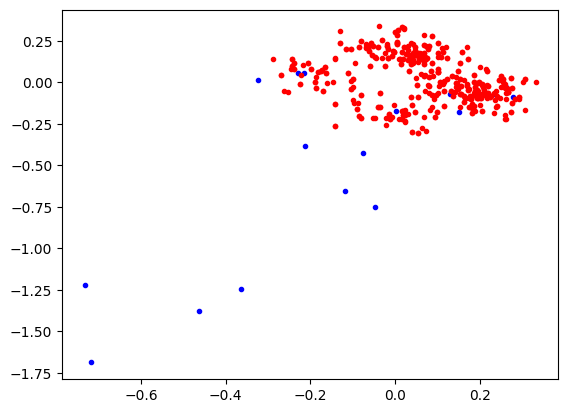

In [25]:
for i in range(len(pca1)):
    plt.plot(pca1[i][0], pca1[i][1], 'b.', label='satie')
    
for i in range(len(pca2)):
    plt.plot(pca2[i][0], pca2[i][1], 'r.', label='sibelius')

# plt.legend()
plt.show()

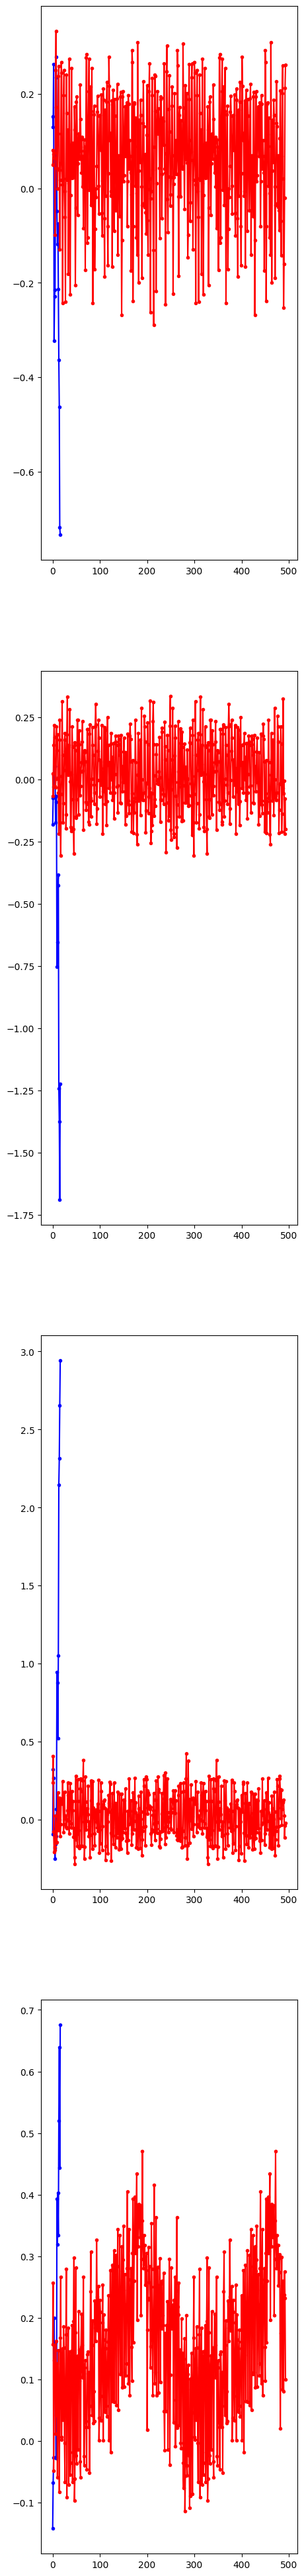

In [26]:
fig, axs = plt.subplots(PCADIM, figsize=(5, 50))

for i in range(PCADIM):
    axs[i].plot(pca1[..., i], 'b.-', label='satie')
    # axs[i].plot(en1[..., i], 'r.-', label='satie')
    axs[i].plot(pca2[..., i], 'r.-', label='sibelius')

# plt.legend()
plt.show()

# Styling

In [27]:
style = reshape(line1[:1])
style_en = autoencoder.encoder(style)
style_pca = pca_project(style_en, principals, mean)

base = line2[:1][..., :2]
base_tones = tones2[:dp.notes_qty]

In [28]:
dtstart = np.random.normal(-1, 0.01, (1, dp.notes_qty, 1))
velstart = np.random.normal(0, 1, (1, dp.notes_qty, 1))
legstart = np.random.normal(0, 1, (1, dp.notes_qty, 1))

dt = tf.Variable(dtstart, dtype=tf.float32) # constraint=lambda t: tf.clip_by_value(t, DTMIN, DTMAX))
vel = tf.Variable(velstart, dtype=tf.float32)
leg = tf.Variable(legstart, dtype=tf.float32)

In [29]:
DT_MAX = 0.1

def dt_norm(dt):
    return -1 * DT_MAX * (1 / (1 + tf.math.exp(-dt + 6))) / dp.normparams[2]

def dt_additive(dt):
    dt = tf.concat([dt_norm(dt), tf.constant(0, shape=(1,1,1), dtype=tf.float32)], axis=1)
    return tf.experimental.numpy.diff(dt, axis=1)

In [30]:
@tf.function
def process(dt, vel, leg):
    dt = dt_additive(dt)
    
    data = tf.concat([base[..., :1], base[..., 1:2] + dt, vel, leg], axis=-1)
    data = tf.reshape(data, [1, data.shape[1] * data.shape[2]])
    if not dp.include_first_tone:
        data = data[:, 1:]
    
    return data


def reconstruct(base, dt, vel, leg):
    dist = (base[..., 1:2] + dt_additive(dt)) * dp.normparams[2]
    vel = vel * dp.normparams[4] + dp.normparams[3]
    leg = leg + 1
    
    return tf.reshape(dist, shape=(dp.notes_qty)), \
            tf.reshape(vel, shape=(dp.notes_qty)), \
            tf.reshape(leg, shape=(dp.notes_qty))

In [31]:
model.predict(process(dt, vel, leg))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.77912134], dtype=float32)>

In [32]:
A = 0
B = 0
C = 1

In [33]:
@tf.function()
def style_loss(encoded): 
    predicted_pca = pca_project(encoded, principals, mean)
    
    loss = tf.reduce_mean(tf.math.square(predicted_pca - style_pca))
    
    return loss

@tf.function()
def content_loss(predicted):
    return tf.constant(0, dtype=tf.float32)

@tf.function()
def quality_loss(predicted, decoded):
    loss = model.predict(predicted, decoded)[0]
    
    return loss

@tf.function()
def overall_loss(dt, vel, leg):
    predicted = process(dt, vel, leg)
    
    encoded = autoencoder.encoder(predicted)
    decoded = autoencoder.decoder(encoded)
    
    lstyle = style_loss(encoded)
    lcontent = content_loss(predicted)
    lquality = quality_loss(predicted, decoded)
    
    ltotal = A * lstyle + B * lcontent + C * lquality 
    
    return ltotal, lstyle, lcontent, lquality

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [35]:
@tf.function()
def train_step(dt, vel, leg):    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(vel)
        tape.watch(leg)
        tape.watch(dt)
        ltotal, lstyle, lcontent, lquality = overall_loss(dt, vel, leg)

    gdt = tape.gradient(ltotal, dt)
    gvel = tape.gradient(ltotal, vel)
    gleg = tape.gradient(ltotal, leg)
    
    opt.apply_gradients([(gvel, vel), (gleg, leg), (gdt, dt)])
    
    return ltotal, lstyle, lcontent, lquality

In [36]:
def graph(line, value):
    x = np.cumsum(line[0, :, 1])
    y = value 

    plt.plot(x, y, 'o-')
    plt.show()

In [37]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 1000

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        ltotal, lstyle, lcontent, lquality = train_step(dt, vel, leg)
    print(f"Step: {step} | total: {ltotal}, style: {lstyle}, content: {lcontent}, quality: {lquality}")

end = time.time()
print("Total time: {:.1f}".format(end-start))

2023-05-25 00:11:04.955872: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Step: 1000 | total: 0.1260381042957306, style: 0.03612808138132095, content: 0.0, quality: 0.1260381042957306
Step: 2000 | total: 0.020479697734117508, style: 0.040658969432115555, content: 0.0, quality: 0.020479697734117508
Step: 3000 | total: 0.0032916541676968336, style: 0.041418615728616714, content: 0.0, quality: 0.0032916541676968336
Step: 4000 | total: 0.0009125751676037908, style: 0.03933478146791458, content: 0.0, quality: 0.0009125751676037908
Step: 5000 | total: 0.0005716709420084953, style: 0.03703774884343147, content: 0.0, quality: 0.0005716709420084953
Step: 6000 | total: 0.0004620113759301603, style: 0.03829013556241989, content: 0.0, quality: 0.0004620113759301603
Step: 7000 | total: 0.0004288631025701761, style: 0.03818696737289429, content: 0.0, quality: 0.0004288631025701761
Step: 8000 | total: 0.00040680315578356385, style: 0.03853244334459305, content: 0.0, quality: 0.00040680315578356385
Step: 9000 | total: 0.00042148801730945706, style: 0.038717832416296005, con

In [38]:
rec_dist, rec_vel, rec_leg = reconstruct(base, dt, vel, leg)

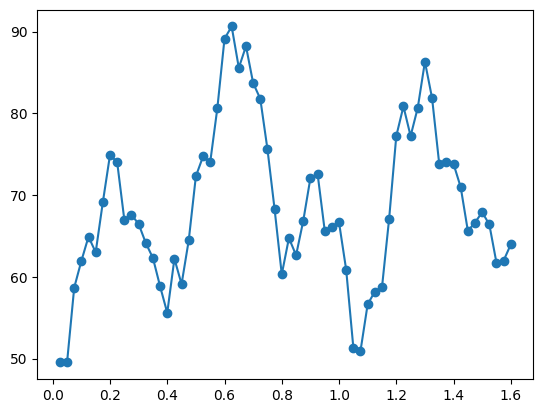

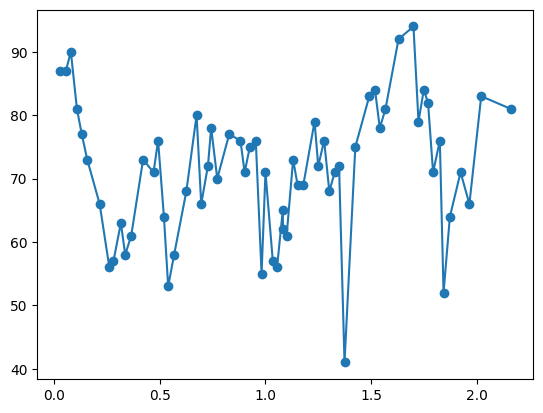

In [39]:
graph(line2, rec_vel)
graph(line1, tf.reshape(line1[0, ..., 2] * dp.normparams[4] + dp.normparams[3], shape=64))

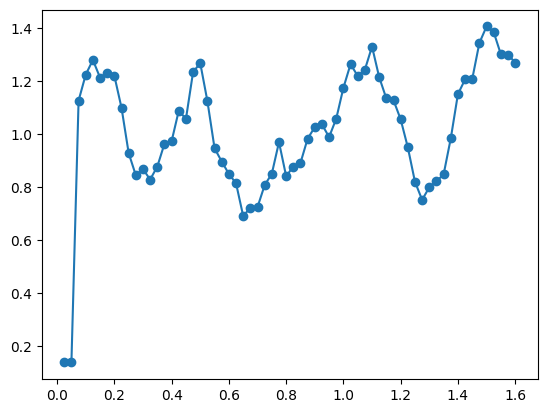

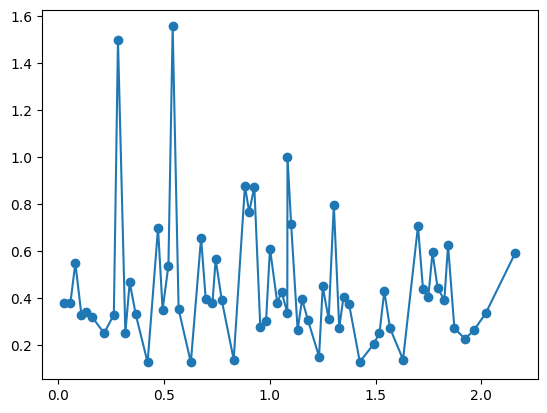

In [41]:
graph(line2, rec_leg)
graph(line1, tf.reshape(line1[0, ..., 3] + 1, shape=64))

In [42]:
events = []
time = 0

for i in range(dp.notes_qty):
    diff = int(rec_dist[i] * mid2.ticks_per_beat * 2)
    
    events.append([time, int(base_tones[i]), int(rec_vel[i]), 'note_on'])
    events.append([time + int(diff * rec_leg[i]), int(base_tones[i]), 0, 'note_off'])
    time += diff
    
events.sort(key=lambda e: e[0])
    
mid = mido.MidiFile(type=0)
mid.ticks_per_beat = mid1.ticks_per_beat
track = mido.MidiTrack()
mid.tracks.append(track)

track.append(mido.Message(events[0][3], note=events[0][1], velocity=events[0][2], time=events[0][0]))
prev = 0

for e in events[1:]:
    diff = e[0] - prev
    prev = e[0]
    
    track.append(mido.Message(e[3], note=e[1], velocity=e[2], time=diff))
    
mid.save('0000_sibelius.mid')